# The Perceptron

**Course**: Computer Vision (911.908)    
**Author**: Roland Kwitt (Dept. of Computer Science, Univ. of Salzburg)       
Winter term 2019/20

---

**Acknowledgments**: Parts of this lecture are taken from Sebastian Raschka's course on [Deep Learning](http://pages.stat.wisc.edu/~sraschka/teaching/stat479-ss2019/) at UW-Madison and the book *Understanding Machine Learning - From Theory to Practice* by Shalev-Schwartz and Ben-David.

---

## Content

- [Perceptron model](#Perceptron-model)
- [Perceptron learning rule](#(Perceptron)-learning-rule)
- [Implementation](#Implementation)
- [Theory](#Theory)


---

## Perceptron model

In this lecture, we discuss the *classic* perceptron model, also known as the **Rosenblatt Perceptron** (Rosenblatt, 1957). If you want to read the original paper, see [here](https://blogs.umass.edu/brain-wars/files/2016/03/rosenblatt-1957.pdf).

**Mathematical model**: Upon receiving an input $\mathbf{x} \in \mathbb{R}^d$, the perceptron computes

$$
\text{output} = \begin{cases}
1 & \text{if}~\sum_{i=1}^{d} w_i x_i > \theta \\
0 & \text{else}
\end{cases}
$$

where $\mathbf{w} = [w_1,\ldots,w_d]^\top$ and $\theta$ (i.e., a scalar) represent the **model parameters**.

Effectively, we compute the inner product between a weight vector $\mathbf{w}$ and the input $\mathbf{x}$ and then apply a threshold function on the output. In most modern treatment of the subject, its more convenient to first define

$$ \phi_\theta(z) = \begin{cases}
1 & \text{if}~z-\theta > 0\\
0 & \text{if}~z-\theta \leq 0
\end{cases}
$$
 
and then write the perceptron computation as

$$
\text{output} = \phi_\theta(\mathbf{w}^\top \mathbf{x})
$$

For our purposes, it will be even more convenient to write $\mathbf{w}=[w_0,w_1,\ldots,w_d]^\top$ and 
$\mathbf{x} = [1,x_1,\ldots,x_d]^\top$ with $w_0 = -\theta$. That is, we include the **bias** term $-\theta = w_0$ into $\mathbf{w}$. This then allows to define

$$
\phi(z) = \begin{cases}
1 & \text{if}~z > 0 \\
0 & \text{if}~z \leq 0
\end{cases}
$$

and write

$$
\text{output} = \phi(\mathbf{w}^\top \mathbf{x})
$$

---
## (Perceptron) learning rule

The perceptron learning rule is quite simple. Given a collection of training points $(\mathbf{x}_i,y_i), i \in \{1,\ldots,m\}$ with $y_i \in \{0,1\}$, we distinguish between the following **three cases**:

1. if correct: do nothing
2. if incorrect (output $0$, desired $1$): add input vector to weight vector
3. if incorrect (output $1$, desired $0$): subtract input vector from weight vector

**Algorithmically**, we have:

Initialize $\mathbf{w}^{(1)} = \mathbf{0}$    
For every training epoch (i.e., one run over all training points):    
&nbsp;&nbsp;&nbsp;&nbsp; $\forall i \in \{1,\ldots,m\}: \hat{y}_i = \phi(\mathbf{w}^\top \mathbf{x}_i)$      
&nbsp;&nbsp;&nbsp;&nbsp; $\forall i \in \{1,\ldots,m\}: \text{err}_i = (y_i - \hat{y}_i)$   
&nbsp;&nbsp;&nbsp;&nbsp; $\forall i \in \{1,\ldots,m\}: \mathbf{w}^{(t+1)} = \mathbf{w}^{(t)} + \text{err}_i \cdot \mathbf{x}_i$    
Terminate if no errors occur, or we reach a certain number of runs over the training data.
    
**Note**: if $\hat{y_i} = y_i$, then we do nothing; otherwise, we either add or subtract the input sample $\mathbf{x}_i$ from the weight vector $\mathbf{w}^{(t)}$.

For our formal analysis (later), lets assume the weight vectors include the bias and that $y_i \in \{-1,+1\}$:

**Input**: $(\mathbf{x}_i,y_i),\ldots,(\mathbf{x}_m,y_m)$    
**Initialize**: $\mathbf{w}^{(1)} = \mathbf{0}$    
**for** $t = 1,2,\ldots$    
&nbsp;&nbsp;&nbsp;&nbsp; **if** $\exists~i~\text{s.t.}~ y_i \langle \mathbf{w}^{(t)},\mathbf{x}_i\rangle \leq 0$ then    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\mathbf{w}^{(t+1)} = \mathbf{w}^{(t)}+y_i \mathbf{x}_i$    
&nbsp;&nbsp;&nbsp;&nbsp;**else**    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **output** $\mathbf{w}^{(t)}$

So, this algorithm (to which we refer to as *Algorithm 1* for later use) terminates once every example is classified correctly.

---

## Implementation

In [4]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Dataset

We use some simple aleady prepared **toy data**. 

In [7]:
data = np.genfromtxt('perceptron_toydata.txt', delimiter='\t')
X, y = data[:, :2], data[:, 2]
y = y.astype(np.int)

print('Class label counts:', np.bincount(y))
print('X.shape:', X.shape)
print('y.shape:', y.shape)

shuffle_idx = np.arange(y.shape[0])
shuffle_rng = np.random.RandomState(123)
shuffle_rng.shuffle(shuffle_idx)

X, y = X[shuffle_idx], y[shuffle_idx]

X_train, X_test = X[shuffle_idx[:70]], X[shuffle_idx[70:]]
y_train, y_test = y[shuffle_idx[:70]], y[shuffle_idx[70:]]

mu, sigma = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

Class label counts: [50 50]
X.shape: (100, 2)
y.shape: (100,)


Visually, the **training** data looks like this:

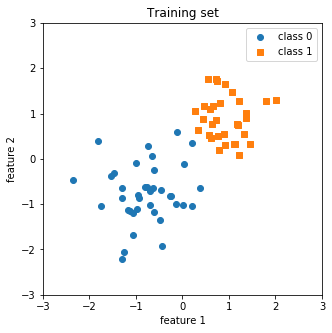

In [8]:
plt.figure(figsize=(5,5))
plt.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], label='class 0', marker='o')
plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], label='class 1', marker='s')
plt.title('Training set')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend()
plt.show()

And the **testing** data looks like this:

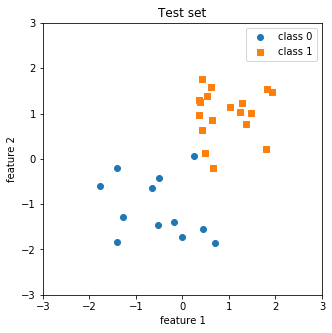

In [9]:
plt.figure(figsize=(5,5))
plt.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], label='class 0', marker='o')
plt.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], label='class 1', marker='s')
plt.title('Test set')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend()
plt.show()

### Model

Lets implement the Perceptron model and its learning rule.

In [11]:
class Perceptron():
    def __init__(self, num_features):
        """Contructor
        
        Args:
            num_features (int): Number of input features
            
        Note that we do not include the bias into the weights here.
        """
        self.num_features = num_features
        self.weights = np.zeros((num_features, 1), dtype=np.float)
        self.bias = np.zeros(1, dtype=np.float)

    def forward(self, x):
        """Computes the perceptron output.
        
        Args:
            x (np.array): Input data
            
        Returns:
            y (np.array): Predictions (0/1)
        """
        linear = np.dot(x, self.weights) + self.bias # <w,x>+b
        predictions = np.where(linear > 0., 1, 0)
        return predictions
        
    def backward(self, x, y):
        """Perceptron error computation.
        
        Args:
            x (np.array): Input features
            y (np.array): Labels of input featuers (0/1)
        """
        predictions = self.forward(x)
        errors = y - predictions
        return errors
        
    def train(self, x, y, epochs):
        """Implementation of the perceptron learning rule.
        
        Args: 
            x (np.array): Input features
            y (np.array): Labels of input features (0/1)
            epochs (int): Number of times to run through the data
        """
        # go over the training data #epoch times
        for e in range(epochs):
            # iterate over all training samples
            for i in range(y.shape[0]):
                errors = self.backward(x[i].reshape(1, self.num_features), y[i]).reshape(-1)
                self.weights += (errors * x[i]).reshape(self.num_features, 1)
                self.bias += errors
                
    def evaluate(self, x, y):
        """Computes accuracy of perceptron model.
        
        Args:
            x (np.array): Input features
            y (np.array): Labels of input features (0/1)
            
        Returns:
            acc (float): Accuracy (in [0,1]) of perceptron model on input data.
        """
        predictions = self.forward(x).reshape(-1)
        accuracy = np.sum(predictions == y) / y.shape[0]
        return accuracy

### Training

In [12]:
ppn = Perceptron(num_features=2)

ppn.train(X_train, y_train, epochs=10)

print('Model parameters:')
print('Weights:')
print('--------')
print(ppn.weights)
print('Bias:')
print('-----')
print(ppn.bias)

Model parameters:
Weights:
--------
[[1.27340847]
 [1.34642288]]
Bias:
-----
[-1.]


### Evaluation

In [13]:
train_acc = ppn.evaluate(X_train, y_train)
test_acc = ppn.evaluate(X_test, y_test)

print('Train set accuracy: %.2f%%' % (train_acc*100))
print('Test set accuracy: %.2f%%' % (test_acc*100))

Train set accuracy: 100.00%
Test set accuracy: 93.33%


We see that the training data is perfectly **linearly separable**; the testing error (on previously unseen data) is also very close.

### Visualizing the decision boundary

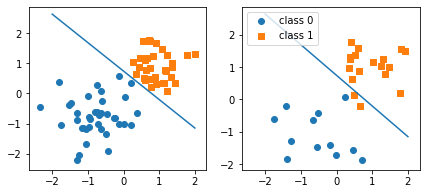

In [14]:
w, b = ppn.weights, ppn.bias

x_min = -2
y_min = ( (-(w[0] * x_min) - b[0]) 
          / w[1] )

x_max = 2
y_max = ( (-(w[0] * x_max) - b[0]) 
          / w[1] )


fig, ax = plt.subplots(1, 2, sharex=True, figsize=(7, 3))

ax[0].plot([x_min, x_max], [y_min, y_max])
ax[1].plot([x_min, x_max], [y_min, y_max])

ax[0].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], label='class 0', marker='o')
ax[0].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], label='class 1', marker='s')

ax[1].scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], label='class 0', marker='o')
ax[1].scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], label='class 1', marker='s')

ax[1].legend(loc='upper left')
plt.show()

---
## Theory

Lets first recap that the perceptron update rule (from *Algorithm 1*) is

$$\mathbf{w}^{(t+1)} = \mathbf{w}^{(t)} + y_i \mathbf{x}_i$$

in case $\mathbf{x}_i$ is incorrectly classified. Also note that

$$y_i \langle \mathbf{w}^{(t+1)},\mathbf{x}_i\rangle =  y_i \langle \mathbf{w}^{(t)} + y_i\mathbf{x}_i,\mathbf{x}_i\rangle = y_i \langle \mathbf{w}^{(t)},\mathbf{x}_i\rangle + \|\mathbf{x}_i\|^2$$

Hence, learning guides the perceptron to be more correct on the $i$-th sample (as $y_i \langle \mathbf{w}^{(t)},\mathbf{x}_i\rangle \leq 0$ for incorrect samples).

**Theorem**: Assume that $(\mathbf{x}_1,y_1),\ldots,(\mathbf{x}_m,y_m)$ is seperable and let $B = \min\{\|\mathbf{w}\|: \forall i \in [m], y_i \langle \mathbf{w},\mathbf{x}_i\rangle \geq 1\}$ . Also, let $R = \max_i \|\mathbf{x}_i\|$. Then, the Perceptron learning algorithm stops after at most $(BR)^2$ iterations and when it stops, it holds that $\forall i \in [m], y_i \langle \mathbf{w},\mathbf{x}_i \rangle > 0$.

**Proof**: By the definition of the stopping criterion of Algorithm 1, if the algorithm stops, all samples are correctly classified.

We will show that if it stops after $T$ iterations, then $T \leq (RB)^2$. To show this, we let $\mathbf{w}^*$ be a vector which achieves the minimum in the definition of $B$ from the theorem above.

Our strategy is to consider the cosine angle between $\mathbf{w}^*$ and $\mathbf{w}^{(T+1)}$. This cosine angle is defined as the inner product between these vectors, divided by the product of their norms, i.e.,

$$
\cos(\alpha) = \frac{\langle \mathbf{w}^*, \mathbf{w}^{(T+1)}\rangle}{\|\mathbf{w}^*\|\|\mathbf{w}^{(T+1)}\|}
$$

Due to the Cauchy-Schwartz inequality, $\langle \mathbf{x},\mathbf{y} \rangle \leq \|\mathbf{x}\| \|\mathbf{y}\|$, we know that $\cos(\alpha) \leq 1$. **If we can show** that

$$
\cos(\alpha) = \frac{\langle \mathbf{w}^*, \mathbf{w}^{(T+1)}\rangle}{\|\mathbf{w}^*\|\|\mathbf{w}^{(T+1)}\|} \geq \frac{\sqrt{T}}{RB}
$$

we are done, as

$$
1 \geq  \frac{\sqrt{T}}{RB} \Rightarrow T \leq (RB)^2
$$



First, lets note that 

$$ \langle \mathbf{w}^*,\mathbf{w}^{(T+1)}\rangle \geq T $$

This is easy to check: Initially, $\mathbf{w}^{(1)} = \mathbf{0}$ and hence 

$$\langle \mathbf{w}^*,\mathbf{w}^{(1)}\rangle = 0$$

Note that, e.g., with $T=2$, we have

$$
\langle \mathbf{w}^*,\mathbf{w}^{(3)}\rangle = (\langle \mathbf{w}^*,\mathbf{w}^{(2}) \rangle - 
\underbrace{\langle \mathbf{w}^*,\mathbf{w}^{(1)}}_{=0} \rangle) + (\langle \mathbf{w}^*,\mathbf{w}^{(3}) \rangle - \langle \mathbf{w}^*,\mathbf{w}^{(2)} \rangle) 
$$

In general, this means that after performing $T$ iterations, we have

$$
\langle \mathbf{w}^*,\mathbf{w}^{(T+1)}\rangle  = \sum_{i=1}^T \left( \langle \mathbf{w}^*,\mathbf{w}^{(t+1}) \rangle - 
\langle \mathbf{w}^*,\mathbf{w}^{(t}) \rangle
\right)
$$

Now, on iteration $t$, if we update with $(\mathbf{x}_i,y_i)$, we have

$$ \langle \mathbf{w}^*,\mathbf{w}^{(t+1)}\rangle - \langle \mathbf{w}^*,\mathbf{w}^{(t)}\rangle = 
\langle \mathbf{w}^*,\mathbf{w}^{(t+1)}-\mathbf{w}^{(t)}\rangle = \langle \mathbf{w}^*,y_i \mathbf{x}_i\rangle \geq 1$$

by construction. This gives us

\begin{align*}
\langle \mathbf{w}^*,\mathbf{w}^{(T+1)}\rangle  & = \sum_{i=1}^T \left( \langle \mathbf{w}^*,\mathbf{w}^{(t+1}) \rangle - 
\langle \mathbf{w}^*,\mathbf{w}^{(t}) \rangle 
\right) \\
& \geq T
\end{align*}

**Hence, we have a bound on the nominator** in our expression for $\cos(\alpha)$. Lets look at the denominator.
We can also easily bound $\| \mathbf{w}^{(T+1)} \|$. In fact,

$$ \| \mathbf{w}^{(t+1)} \|^2 =  \| \mathbf{w}^{(t)} + y_i\mathbf{x}_i \|^2$$

in iteration $t$. Multiplying this out gives 

$$
\| \mathbf{w}^{(t)} + y_i\mathbf{x}_i \|^2 = 
\| \mathbf{w}^{(t)} \|^2 +2y_i \langle \mathbf{w}^{(t)},\mathbf{x}_i\rangle + y_i^2\|\mathbf{x}_i\|^2 \leq
\| \mathbf{w}^{(t)}\|^2 + R^2
$$

This holds, since an update occurs for a falsely classified sample, i.e., $2y_i \langle \mathbf{w}^{(t)},\mathbf{x}_i\rangle \leq 0$ and 
$\|\mathbf{x}_i\|^2$ is at most $R^2$. Since, for iteration $t=1$, we 
have $\| \mathbf{w}^{(1)}\|^2 = 0$, running $T$ iterations and applying the previous inequality gives

$$
\| \mathbf{w}^{(T+1)} \|^2 \leq TR^2 \Rightarrow \| \mathbf{w}^{(T+1)} \| \leq \sqrt{T}R
$$

We are now in the position where we have

1. $\| \mathbf{w}^{(T+1)} \| \leq \sqrt{T}R$
2. $\langle \mathbf{w}^*,\mathbf{w}^{(T+1)}\rangle \geq T$, and
3. $\|\mathbf{w}^*\| = B$

It follows that

$$
\frac{1}{\| \mathbf{w}^{(T+1)} \| \|\mathbf{w}^*\|} \geq B\sqrt{T}R 
$$
and, combined,

$$
 \frac{\langle \mathbf{w}^*, \mathbf{w}^{(T+1)}\rangle}{\|\mathbf{w}^*\|\|\mathbf{w}^{(T+1)}\|} \geq \frac{\sqrt{T}}{BR}
$$
which concludes the proof.

<div class="alert alert-block alert-info">
<b>CAUTION</b>: It is important to note that in the non-seperable case, this no longer holds and we have 
<b>no convergence guarantee</b>. This is why eventually stop after a couple of runs over our data (i.e., the epochs in our implementation).

</div>

